## Why as SDEs/DEs should we care about ML or AI ?

* The role of a SDE or DE should be to solve problems and knowing that there are tools out there and how to to use those tools will give us a perspective on how to solve those problems.
* With the advent of tools like GitHub Copilot and our own AWS CodeWhisperer, a major part of our job - writing code, will be done by AI instead very very soon.
* It's fun!


To quote a paragraph from Andrej Karpathy's [article](https://karpathy.medium.com/software-2-0-a64152b37c35) from 2017

> The “classical stack” of Software 1.0 is what we’re all familiar with — it is written in languages such as Python, C++, etc. It consists of explicit instructions to the computer written by a programmer. By writing each line of code, the programmer identifies a specific point in program space with some desirable behavior.

> In contrast, Software 2.0 is written in much more abstract, human unfriendly language, such as the weights of a neural network.


## Course: FastAI

Link: https://course.fast.ai/

Deep learning is a computer technique to extract and transform data–-with use cases ranging from human speech recognition to animal imagery classification–-by using multiple layers of neural networks. Each of these layers takes its inputs from previous layers and progressively refines them. The layers are trained by algorithms that minimize their errors and improve their accuracy. In this way, the network learns to perform a specified task.

Applications:
1. NLP: ChatGPT
2. Playing games: AlphaGo
3. Image generation: DALL-E & StableDiffusion
4. Recommendation systems.


This deep learning course has been designed with a philosophy that the students should start by implementing the ML applications and then slowly learn about the underlying concepts. And if you think about it, that is how most of us generally work too. Before using a DynamoDB table, we don’t really learn about distributed database systems. We first use it and graduall learn all the theoretical foundations you need, in context, in such a way that you'll see why it matters and how it works. And I believe we should think of AI systems similarly.

* Uses its own library called fastai which is a wrapper over Pytorch.

## Let's build a model to idenitify Dog breeds!

In [5]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [6]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [8]:
bear_types = 'poodle','chihuahua','bulldog'
path = Path('dogs')

# Download file from S3



In [9]:

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} dog')
        download_images(dest, urls=results)

Our folder has image files, as we'd expect:

In [10]:
fns = get_image_files(path)
len(fns)

552

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [11]:
failed = verify_images(fns)
failed

(#0) []

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [ ]:
failed.map(Path.unlink);

In [12]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [13]:
dls = bears.dataloaders(path)

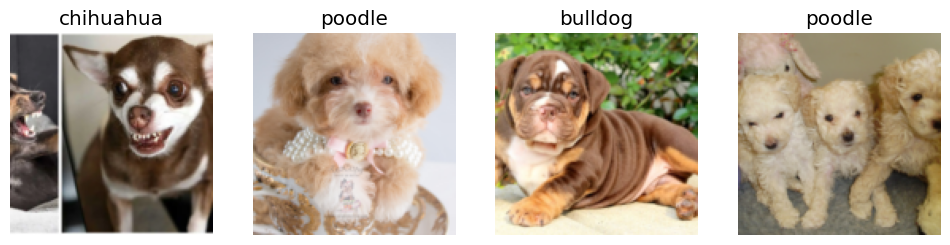

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

In [15]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.064323,0.050871,0.027273,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.168709,0.010271,0.009091,00:08
1,0.117854,0.057459,0.009091,00:08
2,0.091997,0.071367,0.018182,00:08


## Turning Your Model into an Online Application

We are now going to look at what it takes to turn this model into a working online application. We will just go as far as creating a basic working prototype; we do not have the scope in this book to teach you all the details of web application development generally.

### Using the Model for Inference

In [17]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [18]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [19]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [20]:
#hide
ims = ['http://3.bp.blogspot.com/-RCno1rPdLU0/UTyjrniTf1I/AAAAAAAAA8s/UB8HR-Yjopk/s1600/Poodle_Puppy_Wallpaper.jpg']

In [21]:
dest = 'images/poodle.jpg'
download_url(ims[0], dest)

Path('images/poodle.jpg')

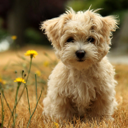

In [22]:
im = Image.open(dest)
im.to_thumb(128,128)

In [23]:
learn_inf.predict('images/poodle.jpg')

('poodle', TensorBase(2), TensorBase([3.4045e-06, 1.0104e-06, 1.0000e+00]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

### It's all just pattern recognition

Another interesting fast.ai student project example comes from Gleb Esman. He was working on fraud detection at Splunk, using a dataset of users' mouse movements and mouse clicks. He turned these into pictures by drawing an image where the position, speed, and acceleration of the mouse pointer was displayed using coloured lines, and the clicks were displayed using [small colored circles](https://www.splunk.com/en_us/blog/security/deep-learning-with-splunk-and-tensorflow-for-security-catching-the-fraudster-in-neural-networks-with-behavioral-biometrics.html), as shown in <<splunk>>. He then fed this into an image recognition model just like the one we've used in this chapter, and it worked so well that it led to a patent for this approach to fraud analytics!

<img alt="Converting computer mouse behavior to an image" width="450" caption="Converting computer mouse behavior to an image" id="splunk" src="images/att_00014.png">

### The Drivetrain Approach

The basic idea is to start with considering your objective, then think about what actions you can take to meet that objective and what data you have (or can acquire) that can help, and then build a model that you can use to determine the best actions to take to get the best results in terms of your objective.

<img src="images/drivetrain-approach.png" id="drivetrain" caption="The Drivetrain Approach">

Let's consider another example: recommendation systems. The *objective* of a recommendation engine is to drive additional sales by surprising and delighting the customer with recommendations of items they would not have purchased without the recommendation. The *lever* is the ranking of the recommendations. New *data* must be collected to generate recommendations that will *cause new sales*. This will require conducting many randomized experiments in order to collect data about a wide range of recommendations for a wide range of customers. This is a step that few organizations take; but without it, you don't have the information you need to actually optimize recommendations based on your true objective (more sales!).

Finally, you could build two *models* for purchase probabilities, conditional on seeing or not seeing a recommendation. The difference between these two probabilities is a utility function for a given recommendation to a customer. It will be low in cases where the algorithm recommends a familiar book that the customer has already rejected (both components are small) or a book that they would have bought even without the recommendation (both components are large and cancel each other out).

As you can see, in practice often the practical implementation of your models will require a lot more than just training a model! You'll often need to run experiments to collect more data, and consider how to incorporate your models into the overall system you're developing. Speaking of data, let's now focus on how to find data for your project.

## Tips on better learning

1. Don't be a perfectionist. Try to do a lot of experiments and keep iterating.
2. Don't get distracted by other courses, articles or any new shiny AI technology.
3. Do your personal projects. An easy way to start is to replicate some other existing product.

## Platforms for learning

1. AWS Sagemaker
2. Google Colab
3. AWS EC2 and many more..

## Instructions of setting up remote Jupyter with AWS EC2 (Use personal AWS account for personal projects)

1. Start an EC2 machine in an AWS account (with a DeepLearning AMI - comes with fastai installed)
2. SSH into it with the keypair file (.pem).
3. Activate pytorch and conda.(source activate pytorch)
4. Refer [this](https://docs.aws.amazon.com/dlami/latest/devguide/setup-jupyter.html) to setup jupyter server and ssh tunnel.
5. Open VSCode and connect to Jupyter remote url.
6. Stop EC2 after work is done.